<a href="https://colab.research.google.com/github/DRodriguez615/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/UFC_PREDICTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

In [0]:
from google.colab import files
uploaded=files.upload()
uploaded

In [3]:
!unzip ufcdata.zip

Archive:  ufcdata.zip
  inflating: data.csv                
  inflating: preprocessed_data.csv   
  inflating: raw_fighter_details.csv  
  inflating: raw_total_fight_data.csv  


In [0]:
df = pd.read_csv('data.csv') # will use the columns: date, r_fighter, and b_fighter
df1 = pd.read_csv('preprocessed_data.csv') #will use this set and a couple columns from the set above
df2 = pd.read_csv('raw_fighter_details.csv') #wont use
df3 = pd.read_csv('raw_total_fight_data.csv') #wont use

In [0]:
import pandas_profiling
pandas_profiling.__version__

In [6]:
# will most likely only use r/b_fighter and date columns from this set
print(df.shape)
df.head()

(5144, 145)


R_fighter       B_fighter  ... B_age R_age
0          Henry Cejudo   Marlon Moraes  ...  31.0  32.0
1  Valentina Shevchenko     Jessica Eye  ...  32.0  31.0
2         Tony Ferguson  Donald Cerrone  ...  36.0  35.0
3         Jimmie Rivera        Petr Yan  ...  26.0  29.0
4           Tai Tuivasa   Blagoy Ivanov  ...  32.0  26.0

[5 rows x 145 columns]

In [0]:
pd.set_option('display.max_rows', 146)
print(df.dtypes.value_counts(), '\n')
df.dtypes

In [0]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
# checking the dates
# train from 1993-2015
# test from 2016-2019
df['date']

0      2019-06-08
1      2019-06-08
2      2019-06-08
3      2019-06-08
4      2019-06-08
          ...    
5139   1993-11-12
5140   1993-11-12
5141   1993-11-12
5142   1993-11-12
5143   1993-11-12
Name: date, Length: 5144, dtype: datetime64[ns]

In [0]:
pd.set_option('display.max_rows', 164)
print(df1.dtypes.value_counts(), '\n')
df1.dtypes

In [11]:
#will use this set
# need to add fighter names and date columns
print(df1.shape)
df1.head()

(3592, 160)


Winner  title_bout  ...  R_Stance_Southpaw  R_Stance_Switch
0    Red        True  ...                  0                0
1    Red        True  ...                  1                0
2    Red       False  ...                  0                0
3   Blue       False  ...                  0                0
4   Blue       False  ...                  1                0

[5 rows x 160 columns]

In [0]:
# stuck on converting this to a float so will skip and come back
# df2['Height']

In [0]:
# need to remove '\' and ' " '
# df2.loc[0, 'Height']

In [0]:
# removing backslash
# df2['Height'].replace('\'','', regex=True, inplace=True)

In [0]:
# # make sure its removed
# height0 = df2.loc[0, 'Height']
# print(height0)

In [0]:
# stripping (")
# newheight0.strip().strip('"')

In [0]:
# add decimal between to make float
# newheight0 = height0[:1] +'.'+ height0[1:]
# print(newheight0)

In [0]:
# newheight0.strip().strip('"')

In [0]:
# need to get rid of the extra space between decimal and 4??
# type(int(newheight0.strip().strip(' "')))

In [0]:
# Winner column will be the target
# Classification problem
# 2 classes: red and blue
# classes imbalanced, red is twice the blue column
# majority class frequency (red) falls between >=50% and <70% range
# evaluation metric = accuracy
# will do a time-based split
y = df1['Winner']
y.value_counts(normalize=True)

Red     0.662584
Blue    0.337416
Name: Winner, dtype: float64

In [0]:
# adding these 3 columns to dataset df1
df1['date'] = df['date']
df1['R_fighter'] = df['R_fighter']
df1['B_fighter'] = df['B_fighter']
print(df1.shape)
df1.head()

(3592, 163)


Winner  title_bout  ...             R_fighter       B_fighter
0    Red        True  ...          Henry Cejudo   Marlon Moraes
1    Red        True  ...  Valentina Shevchenko     Jessica Eye
2    Red       False  ...         Tony Ferguson  Donald Cerrone
3   Blue       False  ...         Jimmie Rivera        Petr Yan
4   Blue       False  ...           Tai Tuivasa   Blagoy Ivanov

[5 rows x 163 columns]

In [0]:
# red_fighters with current win streaks of 10 or more
# red win streak = rws
# tt = top ten
rws = df1[['R_fighter', 'R_current_win_streak']]
rws_tt = rws.loc[rws['R_current_win_streak'] >=10.0]
rws_tt = pd.DataFrame(rws_tt)
rws_tt

R_fighter  R_current_win_streak
2             Tony Ferguson                  11.0
60            Arjan Bhullar                  13.0
186         Israel Adesanya                  12.0
254   Olivier Aubin-Mercier                  10.0
255       Katlyn Chookagian                  10.0
306       Humberto Bandenay                  13.0
561           Frankie Edgar                  11.0
624               Sam Alvey                  12.0
781              Matt Brown                  11.0
907         Patrick Cummins                  10.0
1147      Dmitrii Smoliakov                  12.0
1630           Stipe Miocic                  11.0
1871             Matt Brown                  10.0
1994         Seth Baczynski                  11.0
2110           Shawn Jordan                  16.0
2177         Yair Rodriguez                  10.0
2285         Yancy Medeiros                  15.0
2354         Corey Anderson                  14.0
2569         Felipe Arantes                  13.0
2667         Brian Ebersole                  12.0
2753       Keith Wisniewski                  11.0
2812              Ed Herman                  10.0
3581              Luiz Cane                  10.0

In [0]:

values = rws_tt['R_current_win_streak']
labels = rws_tt['R_fighter']
colors = ['red']


fig = px.pie(rws_tt['R_fighter'], values=values, names=labels, color_discrete_sequence=px.colors.sequential.Redor, title= 'Top Ten Fighters with the longets WIN streaks from Red Corner')
           
fig.show()

In [0]:
import plotly.express as px

values = df.Winner.value_counts()
labels = df.Winner.unique()
colors = ['red', 'blue', 'black']


fig = px.pie(df1['Winner'], values=values, names=labels,
             color=colors, title= 'Winner By Corner Color',
             color_discrete_sequence=['red', 'blue', 'black'])
fig.show()

In [0]:
# blue_fighters with current win streaks of 10 or more
# not as many compared to red fighters
# blue win streak = bws
bws = df1[['B_fighter', 'B_current_win_streak']]
bws.loc[bws['B_current_win_streak'] >=8.0]

B_fighter  B_current_win_streak
112          Anthony Pettis                   9.0
206   Jairzinho Rozenstruik                   8.0
597           Peter Sobotta                  12.0
740           Angela Magana                  10.0
955            Dennis Siver                   8.0
1254           Thiago Alves                   8.0
3083         Justin Edwards                   8.0

In [0]:
# shows no missing values
df1.isnull().sum().sum()

0

In [0]:
# train from 1993-2015
# test from 2016-2019

train = df1[df1['date'].dt.year <= 2016]
test = df1[df1['date'].dt.year >= 2017]


train.shape, test.shape

((2444, 163), (1148, 163))

In [0]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df1, minimal=True).to_notebook_iframe()

profile

In [0]:
from sklearn.model_selection import train_test_split
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Winner'], random_state=42)
train.shape, val.shape, test.shape

((1955, 163), (489, 163), (1148, 163))

In [0]:
target = 'Winner'
features = train.columns.drop([target, 'date', 'R_Height_cms', 'B_Height_cms' ])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# getting the baseline
y_train.value_counts(normalize=True)

Red     0.712532
Blue    0.287468
Name: Winner, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
pd.unique(y_pred), len(y_pred)

(array(['Red'], dtype=object), 1955)

In [0]:
accuracy_score(y_train, y_pred)

0.7125319693094629

In [0]:
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.7116564417177914

In [0]:
# logistic regressionCV
# without using pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler


encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
print(X_train_encoded.shape, X_val_encoded.shape)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

log_regcv = LogisticRegressionCV(cv=25, n_jobs=-1, random_state=42)
log_regcv.fit(X_train_scaled, y_train)
print('Validation Accuracy', log_regcv.score(X_val_scaled, y_val))

(1955, 1787) (489, 1787)
Validation Accuracy 0.7116564417177914


In [0]:
from sklearn.linear_model import LogisticRegression
# works slightly better without the cross validation using imputed values
# only beat baseline accuracy by .2%.   :(
log_reg = LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1)
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.7137014314928425


In [0]:
# X_val predictions with logistic regression
log_reg.predict(X_val_imputed)

array(['Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue',
       'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Red',
       'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Blue',
       'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
       'Red', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Red',
       'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue',
       'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Blue', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
       'Red', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
   

In [0]:
# compare to X_val predictions
y_val.head(20)

3414     Red
2828     Red
3547     Red
2038    Blue
3113     Red
1154     Red
2252     Red
1216    Blue
2356     Red
2042     Red
3462     Red
3412     Red
2594     Red
1323     Red
3558     Red
2209     Red
1534    Blue
1240     Red
2355     Red
2474    Blue
Name: Winner, dtype: object

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from pdpbox import pdp

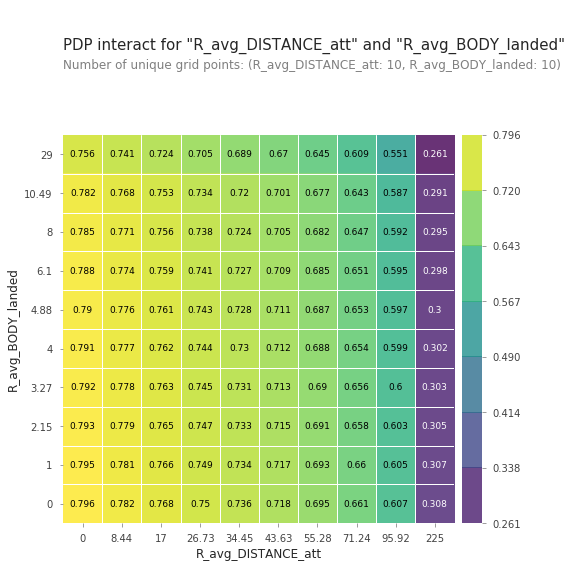

In [0]:
# obvisouly the closer the distance of the attempt 
# the more body shots landed
features = ['R_avg_DISTANCE_att', 'R_avg_BODY_landed']

interaction = pdp_interact(
    model=log_reg,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [0]:
# random forest classification 
# performs a little better than log_reg by 1% with 50 estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


target = 'Winner'
features = train.columns.drop([target, 'date', 'R_Height_cms', 'B_Height_cms' ])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

rf = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
rf.fit(X_train, y_train)
print('Validation Accuracy', rf.score(X_val, y_val))

Validation Accuracy 0.7239263803680982


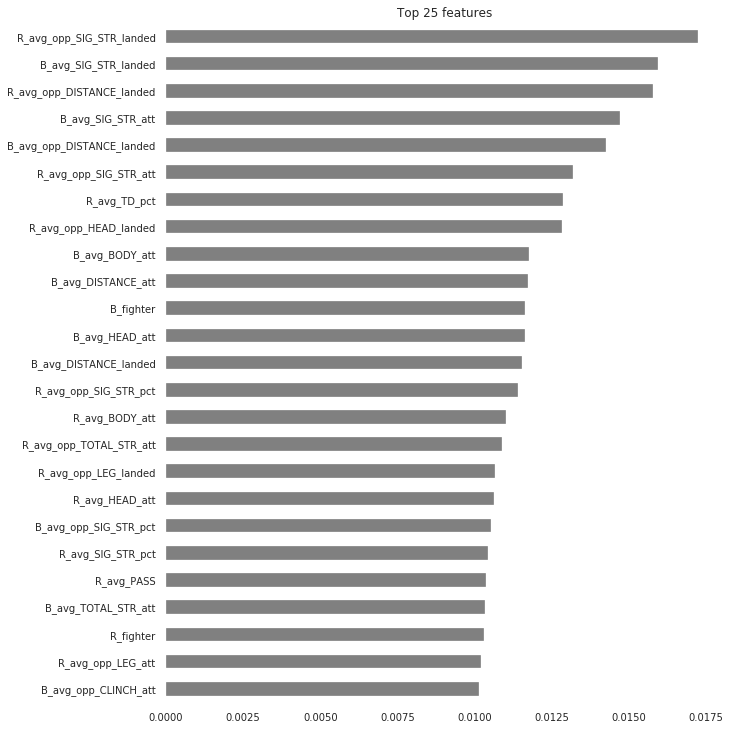

In [0]:
# Get feature importances
fi = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(fi.feature_importances_, X_train.columns)

# Plot feature importances
# top 25 features
n = 25
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
# drop column performance
# "top" feature 
column  = 'R_avg_opp_SIG_STR_landed'


# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without R_avg_opp_SIG_STR_landed: 0.7034764826175869
Validation Accuracy with R_avg_opp_SIG_STR_landed: 0.7137014314928425
Drop-Column Importance for R_avg_opp_SIG_STR_landed: 0.010224948875255602


In [0]:
# trying more features
# before sequence of the feature to be permuted
feature = 'R_avg_TD_pct'
X_val[feature].head()

3414    0.427778
2828    0.443333
3547    0.555556
2038    0.633333
3113    0.666667
Name: R_avg_TD_pct, dtype: float64

In [0]:
# permute
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

In [0]:
# after sequence has changed
X_val_permuted[feature].head()

3414    0.248000
2828    0.243000
3547    0.428571
2038    0.215000
3113    0.131818
Name: R_avg_TD_pct, dtype: float64

In [0]:
# Getting the permutation importance

score_permuted = pipeline.score(X_val_permuted, y_val) #Calc. accuracy on the permuted val dataset

print(f'Validation accuracy with {feature}: {score_with}')
print(f'Validation accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation importance: {score_with - score_permuted}')

Validation accuracy with R_avg_TD_pct: 0.7137014314928425
Validation accuracy with R_avg_TD_pct permuted: 0.7137014314928425
Permutation importance: 0.0


In [0]:
# trying a different feature
feature = 'R_avg_BODY_att'
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

score_permuted = pipeline.score(X_val_permuted, y_val) #Calc. accuracy on the permuted val dataset

print(f'Validation accuracy with {feature}: {score_with}')
print(f'Validation accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation importance: {score_with - score_permuted}')

Validation accuracy with R_avg_BODY_att: 0.7137014314928425
Validation accuracy with R_avg_BODY_att permuted: 0.7239263803680982
Permutation importance: -0.010224948875255713


In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
# calculating permutation importances
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [0]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

B_avg_opp_DISTANCE_landed    0.009407
B_avg_opp_HEAD_att           0.008998
B_avg_opp_SIG_STR_pct        0.007362
B_avg_HEAD_landed            0.006544
R_avg_opp_DISTANCE_att       0.006544
                               ...   
R_avg_HEAD_landed           -0.006135
R_avg_opp_DISTANCE_landed   -0.007362
B_avg_BODY_landed           -0.008180
R_avg_opp_LEG_landed        -0.008180
R_avg_opp_TD_pct            -0.008589
Length: 159, dtype: float64

In [0]:
# displaying permutation importances
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

In [0]:
print('Shape before removing features: ', X_train.shape)

Shape before removing features:  (1955, 159)


In [0]:
minimum_importance = 0

mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]


In [0]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.7239263803680982


In [0]:
X_test = X_test[features]

In [0]:
# xgboost
from sklearn.metrics import r2_score
from xgboost import XGBClassifier

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
# fit pipeline
gb.fit(X_train, y_train)

# y_pred = pipeline.predict(X_val)
# print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['R_fighter'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'R_fighter',
                                          'data_type': dtype('O'),
                                          'mapping': Mark Hunt                1
Jose Aldo                2
Francis Ngannou          3
Gegard Mousasi           4
Tony Ferguson            5
                      ... 
Kamal Shalorus         740
Horacio Gutierrez      741
Iliarde Santos         742
Krzysztof Soszynski    743
NaN                     -2
Le...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                          

In [0]:
from sklearn.metrics import accuracy_score

y_pred = gb.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7096114519427403


In [0]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

gb = XGBClassifier(
    scale_pos_weight=0.1,
    n_estimators=1000,
    max_depth = 3,
    learning_rate = 0.5,
    n_jobs=-1,
)
eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

gb.fit(X_train_encoded, y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds=100,
          )

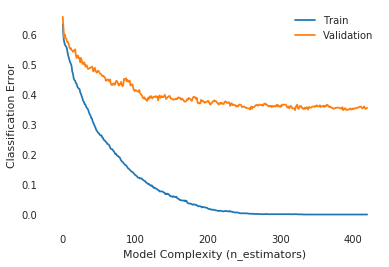

In [0]:
results = gb.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
# plt.ylim((0.10, 0.35))
plt.legend();

In [0]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

gb = XGBClassifier(n_estimators=1000, n_jobs=-1)
gb.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.694992	validation_1-auc:0.631124
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.704944	validation_1-auc:0.625194
[2]	validation_0-auc:0.718577	validation_1-auc:0.63144
[3]	validation_0-auc:0.72779	validation_1-auc:0.647744
[4]	validation_0-auc:0.74089	validation_1-auc:0.641824
[5]	validation_0-auc:0.739613	validation_1-auc:0.643016
[6]	validation_0-auc:0.750374	validation_1-auc:0.647031
[7]	validation_0-auc:0.75688	validation_1-auc:0.646307
[8]	validation_0-auc:0.759752	validation_1-auc:0.645971
[9]	validation_0-auc:0.763556	validation_1-auc:0.647133
[10]	validation_0-auc:0.77145	validation_1-auc:0.649272
[11]	validation_0-auc:0.772843	validation_1-auc:0.646603
[12]	validation_0-auc:0.775096	validation_1-auc:0.647
[13]	validation_0-auc:0.77833	validation_1-auc:0.647999
[14]	validation_0-auc:0.784635	validation_1-auc:0.655285
[15]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
X_train.shape, X_val.shape, X_test.shape


((1955, 56), (489, 56), (1148, 56))

In [0]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = gb.predict_proba(X_test_processed, ntree_limit=50) [:, class_index]
print(f'Validation ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba))

Validation ROC AUC for class 1:
0.6194416004870085


In [0]:
X_test_predicted = model.predict(X_test_processed)
X_test_predicted = pd.DataFrame(X_test_predicted)
X_test_predicted.head(15)

0
0    Red
1    Red
2    Red
3    Red
4    Red
5    Red
6    Red
7   Blue
8    Red
9    Red
10   Red
11   Red
12   Red
13  Blue
14   Red

In [0]:
y_test.head(15)

0      Red
1      Red
2      Red
3     Blue
4     Blue
5      Red
6      Red
7     Blue
8     Blue
9      Red
10    Blue
11     Red
12    Blue
13    Blue
14     Red
Name: Winner, dtype: object